# Bias-Variance Tradeoff

Mean Squared Error (MSE) definition:

$$ MSE = \langle (\hat{y} - y)^2 \rangle = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2$$

Residual Variance:

$$ Var = Var[\Delta y] = Var[\hat{y} - y] = \langle (\hat{y} - y)^2 \rangle - \langle \hat{y} - y \rangle^2$$

Therefore

$$ MSE = Var + Bias^2$$

Where:

$$ Bias = \langle \hat{y} - y \rangle$$

In [43]:
import numpy as np
import pandas as pd

import numpy.random as rd

import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.neighbors import KNeighborsRegressor, KernelDensity

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [44]:
data = np.load('../data/biasvar.npy')

In [45]:
x, y, sy = data.T

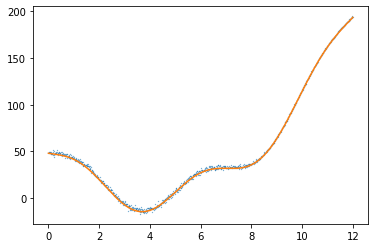

In [46]:
plt.plot(x, sy, '.', ms=.5)
plt.plot(x, y)

In [47]:
n_neighbors = np.arange(10, 160)
cv = 10

kfolder = KFold(n_splits=cv, shuffle=True)

In [14]:
rows = []

preds = defaultdict(list)

for train_index, test_index in kfolder.split(x):
    
    X_train, y_train = x[train_index, np.newaxis], sy[train_index]
    X_test, y_test = x[test_index, np.newaxis], y[test_index]
    
    for n in n_neighbors:
        
        model = KNeighborsRegressor(n_neighbors=n)
        
        model.fit(X_train, y_train)
        
        y_pred_test = model.predict(X_test)
        
        dy_test = y_pred_test - y_test
        
        rows.append({
            'Bias': dy_test.mean(),
            'Std': dy_test.std(),
            'RMSE': np.sqrt(mean_squared_error(y_pred_test, y_test)),
            'n_neighbors': n
        })
        
        preds[n].append(np.column_stack([X_test.ravel(), y_pred_test, y_test]))

In [49]:
df = pd.DataFrame(rows)

df.head()

,Bias,Std,RMSE,n_neighbors
0,1.169674,0.543936,1.289962,10
1,1.174596,0.534502,1.290492,11
2,1.146635,0.539086,1.267038,12
3,1.132003,0.549907,1.258503,13
4,1.148118,0.553763,1.274687,14


In [50]:
df.loc[df.n_neighbors == 30]

,Bias,Std,RMSE,n_neighbors
20,1.071977,0.840688,1.362311,30
170,1.114297,0.757705,1.347507,30
320,1.208444,0.460061,1.293056,30
470,1.252233,0.374109,1.306922,30
620,1.110264,0.591897,1.258184,30
770,1.214187,0.735477,1.419570,30
920,1.227853,0.413221,1.295521,30
1070,1.217213,0.632999,1.371968,30
1220,1.268709,0.402960,1.331164,30
1370,1.305010,0.410898,1.368169,30


In [51]:
df_ = df.groupby('n_neighbors').mean()

In [52]:
df_.Bias = np.abs(df_.Bias)

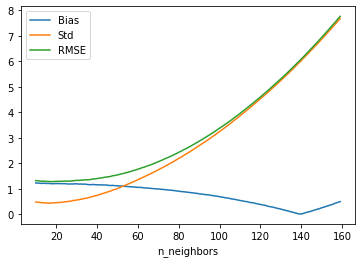

In [53]:
df_.plot(use_index=True)

In [54]:
ns = [20, 40, 50, 100, 140, 150]

(-2, 4)

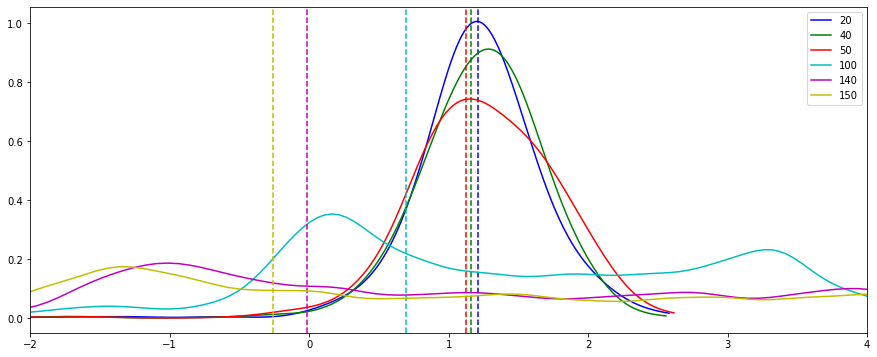

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 6))

for n, c in zip(ns, 'bgrcmy'):
    
    sample = np.row_stack(preds[n])
    sample = sample[:, 1] - sample[:, 2]
    
    KDE = KernelDensity(bandwidth=.2).fit(sample.reshape(-1, 1))
    
    x = np.linspace(sample.min(), sample.max(), 500).reshape(-1, 1)
    PDF = np.exp(KDE.score_samples(x))
    
    bias = sample.mean()
    
    plt.plot(x, PDF, c, label=n)
    
    ax.axvline(bias, color=c, ls='dashed')
    
plt.legend()
    
ax.set_xlim(-2, 4)

(40, 60)

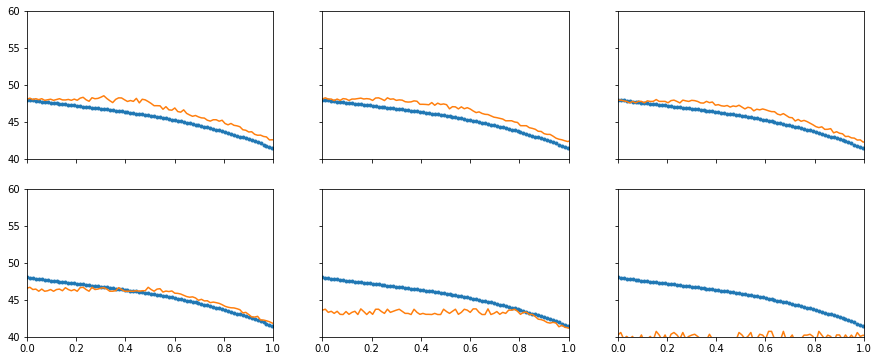

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 6), sharex=True, sharey=True)

axes = axs.flatten()

for ax, n in zip(axes, ns):
    
    sample = np.row_stack(preds[n])
    
    x = sample[:, 0]
    yp = sample[:, 1]
    y = sample[:, 2]
    
    i = x.argsort()
    
    ax.plot(x[i], y[i], '.')
    ax.plot(x[i], yp[i], '-')
    
axes[0].set_xlim(0, 1)
axes[0].set_ylim(40, 60)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

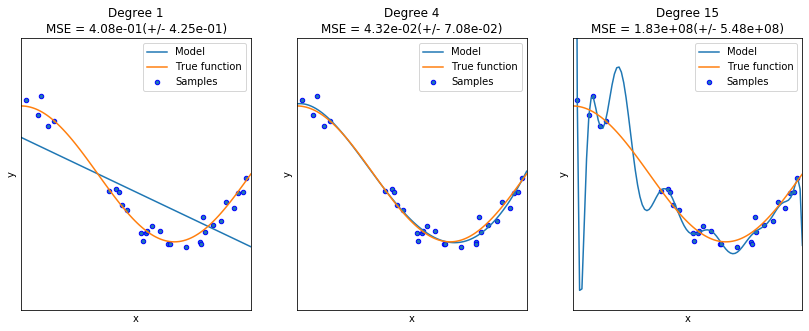

In [34]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

If our algorithm shows high bias, the following actions might help:

1. Add more features.
2. Use fewer samples.
3. Decrease regularization.

If our algorithm shows high variance, the following actions might help:

1. Use fewer features.
2. Use more training samples.
3. Increase Regularization.

## Other scores

https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics